# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Filesystem-parameters" data-toc-modified-id="Filesystem-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filesystem parameters</a></div><div class="lev1 toc-item"><a href="#Grism-and-Filter-Properties" data-toc-modified-id="Grism-and-Filter-Properties-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grism and Filter Properties</a></div><div class="lev1 toc-item"><a href="#Load-Catalogues" data-toc-modified-id="Load-Catalogues-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Catalogues</a></div><div class="lev1 toc-item"><a href="#Load-Redshift-Estimates" data-toc-modified-id="Load-Redshift-Estimates-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Redshift Estimates</a></div><div class="lev1 toc-item"><a href="#Compute-Galaxy-Size" data-toc-modified-id="Compute-Galaxy-Size-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compute Galaxy Size</a></div><div class="lev1 toc-item"><a href="#Compute-&quot;Cleanliness&quot;-for-Stamps" data-toc-modified-id="Compute-&quot;Cleanliness&quot;-for-Stamps-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Compute "Cleanliness" for Stamps</a></div><div class="lev1 toc-item"><a href="#Merge-Catalogue-quantities-with-cleanliness-metric" data-toc-modified-id="Merge-Catalogue-quantities-with-cleanliness-metric-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Merge Catalogue quantities with cleanliness metric</a></div><div class="lev1 toc-item"><a href="#Compute-S/N-for-central-1000Å-of-G141-grism" data-toc-modified-id="Compute-S/N-for-central-1000Å-of-G141-grism-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Compute S/N for central 1000Å of G141 grism</a></div><div class="lev1 toc-item"><a href="#Plot-S/N-versus-catalogue-parameters-for-sub-threshold-values-of-CLEANLINESS" data-toc-modified-id="Plot-S/N-versus-catalogue-parameters-for-sub-threshold-values-of-CLEANLINESS-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Plot S/N versus catalogue parameters for sub-threshold values of CLEANLINESS</a></div><div class="lev1 toc-item"><a href="#Plot-S/N-versus-flux-in-central-1000Å-of-G141-grism" data-toc-modified-id="Plot-S/N-versus-flux-in-central-1000Å-of-G141-grism-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Plot S/N versus flux in central 1000Å of G141 grism</a></div>

# Imports

In [1]:
import astropy.io.fits as astrofits
import astropy.units as astrounits
import numpy as np
import scipy as sp
import scipy.stats as spstats
import pandas as pd
import glob
import gc
import re
import pathlib
from IPython.core.display import display
import matplotlib
from matplotlib import pyplot as mplplot
%matplotlib inline

# Filesystem parameters

In [2]:
pointingId = 96
pipelineVersion = 6.2
dataPath = '/Volumes/ramon2_wisps/data/V{}'.format(pipelineVersion)
pointingPath = '{}/Par{}'.format(dataPath, pointingId)
objectCatalogPaths = glob.glob('{}/DATA/DIRECT_GRISM/fin*.cat'.format(pointingPath))
g141StampPaths = glob.glob('{}/G141_DRIZZLE/*mef*.fits'.format(pointingPath))
g102StampPaths = glob.glob('{}/G102_DRIZZLE/*mef*.fits'.format(pointingPath))
g141SpectraPaths = glob.glob('{}/Spectra/*G141*.dat'.format(pointingPath))
g102SpectraPaths = glob.glob('{}/Spectra/*G102*.dat'.format(pointingPath))
redshiftEstimatesPath = '../Par96_estimates.fits'

# Grism and Filter Properties

In [3]:
defaultGrismToFilterMap = {102 : [110, 140, 160], 
                           141 : [160, 140, 110]}

# Retrieved from: The online Filter Profile Service (http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=HST&gname2=WFC3_IR)
defaultFilterPivotWavelengths = {110 : 11534.46*astrounits.angstrom,
                                 160 : 15370.33*astrounits.angstrom,
                                 102 : 9989.59*astrounits.angstrom}

# Characteristics of the blue and red grisms.
defaultGrismWavelengthRanges = {102 : (800,1150)*astrounits.nanometer,
                                141 : (1075,1700)*astrounits.nanometer}

defaultGrismCrossoverWavelength = 0.5*(defaultGrismWavelengthRanges[102][1] + defaultGrismWavelengthRanges[141][0])

defaultGrismResolvingPowers = {102 : 210,
                               141 : 130}

defaultGrismResolvingPowerWavelengths = {102 : 1000*astrounits.nanometer,
                                         141 : 1400*astrounits.nanometer}

# Retrieved from: http://www.stsci.edu/hst/wfc3/analysis/grism_obs/wfc3-grism-resources.html
defaultGrismDispersionsNmPerPixel = {102 : 2.45*astrounits.nanometer,
                                     141 : 4.65*astrounits.nanometer}

defaultGrismPixelBounds = {102 : np.linspace(start=defaultGrismWavelengthRanges[102][0],
                                             stop=defaultGrismWavelengthRanges[102][1],
                                             num=(defaultGrismWavelengthRanges[102][1] - defaultGrismWavelengthRanges[102][0])/defaultGrismDispersionsNmPerPixel[102]
                                             ),
                           141 : np.linspace(start=defaultGrismWavelengthRanges[141][0],
                                             stop=defaultGrismWavelengthRanges[141][1],
                                             num=(defaultGrismWavelengthRanges[141][1] - defaultGrismWavelengthRanges[141][0])/defaultGrismDispersionsNmPerPixel[141]
                                             )
                           }

# Load Catalogues

In [4]:
catalogueColumns = ['RA_DEC_NAME',
'NUMBER',
'X_IMAGE',
'Y_IMAGE',
'A_IMAGE',
'B_IMAGE',
'THETA_IMAGE',
'X_WORLD',
'Y_WORLD',
'A_WORLD',
'B_WORLD',
'THETA_WORLD',
'MAG_AUTO',
'MAGERR_AUTO',
'CLASS_STAR',
'FLAGS']

catalogueDescriptions = ['Synthetic Name',
'Running object number',
'Object position along x',
'Object position along y',
'Profile RMS along major axis',
'Profile RMS along minor axis',
'Position angle (CCW/x)',
'Barycenter position along world x axis',
'Barycenter position along world y axis',
'Profile RMS along major axis (world units)',
'Profile RMS along minor axis (world units)',
'Position angle (CCW/world-x)',
'Kron-like elliptical aperture magnitude',
'RMS error for AUTO magnitude',
'S/G classifier output',
'Extraction flags']

catalogueUnits = [None,
None,
'pixel',
'pixel',
'pixel',
'pixel',
'deg',
'deg',
'deg',
'deg',
'deg',
'deg',
'mag',
'mag',
 None,
 None]

In [5]:
objectCatalogues = { pathlib.Path(path).stem : pd.read_csv(path,
                                                           delim_whitespace=True,
                                                           header=None,
                                                           names=catalogueColumns, 
                                                           comment='#', 
                                                           engine='c') for path in objectCatalogPaths }

# Load Redshift Estimates
Also compute extimates of the error on the reshift estimates by scanning the likelihood space bracketing the maximum until the the enclosed area is a specified fraction of the total sum. Two options have been implemented:
1. `getSymmetricBracketingPercentile` accumulates equal sums on either side of the best fit value unless the boundary of the redshift space is encountered. This means that the final interval may contain a smaller fraction of the total probability than specified.
2. `getBracketingPercentile` continues to accumulate until the specified fraction of the total probability is accumulated. This means that truncation by one boundary of redshift space will produce a larger counter-directional error to compensate.

,MAX_REDSHIFT,MIN_REDSHIFT,REDSHIFT,REDSHIFT_OBJECT
0,2.70,0.00,1.05,1
1,2.91,0.00,0.03,2
2,2.91,0.00,0.06,3
3,2.94,0.00,0.30,4
4,2.85,0.00,0.72,5
5,2.61,0.03,1.32,6
6,2.85,0.00,0.66,7
7,2.94,0.00,0.60,8
8,2.88,0.00,1.35,10
9,3.00,0.30,1.92,11


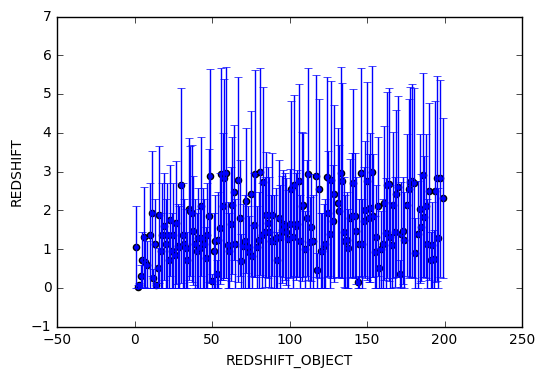

In [6]:
def getSymmetricBracketingPercentile(bestRedshift, redshifts, probabilities, fraction) :
    indexOfBestRedshift = np.where(redshifts == bestRedshift)
    probabilitySum = np.sum(probabilities)
    probabilitySumFraction = fraction*0.5*probabilitySum
    # scan backwards
    backwardSum = 0
    lowerBound = None
    for index in range(indexOfBestRedshift[0][0], 0, -1) :
        backwardSum += probabilities[index]
        #print(index, probabilities[index], backwardSum, redshifts[index], probabilitySum, probabilitySumFraction)
        if backwardSum > probabilitySumFraction :
            lowerBound = redshifts[index]
            break
        
    # scan forwards
    forwardSum = 0
    upperBound = None
    for index in range(indexOfBestRedshift[0][0], len(probabilities)) :
        forwardSum += probabilities[index]
        if forwardSum > probabilitySumFraction :
            upperBound = redshifts[index]
            break
    return (lowerBound if lowerBound is not None else redshifts[0], upperBound if upperBound is not None else redshifts[-1])

def getBracketingPercentile(bestRedshift, redshifts, probabilities, fraction) :
    indexOfBestRedshift = np.where(redshifts == bestRedshift)
    probabilitySum = np.sum(probabilities)
    probabilitySumFraction = fraction*probabilitySum
    enclosedSum = probabilities[indexOfBestRedshift[0][0]]
    bracketSize = 1
    stillAdding = True
    while enclosedSum < probabilitySumFraction and stillAdding:
        stillAdding = False
        if indexOfBestRedshift[0][0] - bracketSize > 0 :
            enclosedSum += probabilities[indexOfBestRedshift[0][0] - bracketSize]
            stillAdding = True
        if indexOfBestRedshift[0][0] + bracketSize < len(probabilities) :
            enclosedSum += probabilities[indexOfBestRedshift[0][0] + bracketSize]
            stillAdding = True
        bracketSize += 1
    return (redshifts[max(0, indexOfBestRedshift[0][0] - bracketSize)], redshifts[min(indexOfBestRedshift[0][0] + bracketSize, len(redshifts) -1)])

redshiftEstimatesHdus = astrofits.open(redshiftEstimatesPath)
redshiftEstimateTable = redshiftEstimatesHdus[1].data
redshiftErrors = [ getBracketingPercentile(*redshiftPdfData, 0.9) for redshiftPdfData in zip(redshiftEstimateTable['redshift'], redshiftEstimateTable['redshift_space'], redshiftEstimateTable['chisq']) ]
redshiftEstimatesFrame = pd.DataFrame.from_dict({'REDSHIFT_OBJECT' : redshiftEstimateTable['target'].byteswap().newbyteorder() ,
                                                 'REDSHIFT' : redshiftEstimateTable['redshift'].byteswap().newbyteorder(), 
                                                 'MIN_REDSHIFT' : [minRedshift for minRedshift, _ in redshiftErrors], 
                                                 'MAX_REDSHIFT' : [maxRedshift for _, maxRedshift in redshiftErrors] } )

cutRedshiftEstimatesFrame = redshiftEstimatesFrame[redshiftEstimatesFrame['REDSHIFT_OBJECT'] < 200]
display(cutRedshiftEstimatesFrame)
errors = np.array([[ z - minZ for minZ, z in zip(cutRedshiftEstimatesFrame['MIN_REDSHIFT'], cutRedshiftEstimatesFrame['REDSHIFT']) ],
                   [ maxZ - z for maxZ, z in zip(cutRedshiftEstimatesFrame['MAX_REDSHIFT'], cutRedshiftEstimatesFrame['REDSHIFT']) ]
                   ])
                                                                                     
cutRedshiftEstimatesFrame.plot.scatter(x='REDSHIFT_OBJECT', 
                                    y='REDSHIFT', 
                                    yerr=errors)

# Compute Galaxy Size
Maybe `A_WORLD` suffices for this?

# Compute "Cleanliness" for Stamps

In [7]:
g141StampCleanlinesses = []
g102StampCleanlinesses = []

g141StampObjects = []
g102StampObjects = []

for stampPath in g141StampPaths :
    stampHdus = astrofits.open(stampPath)
    contamExtension = stampHdus['CON'].data
    modelExtension = stampHdus['MOD'].data
    
    multipliedExtensions = (contamExtension > 0) & (modelExtension > 0)
    cleanliness = np.sum(multipliedExtensions)/np.sum((modelExtension > 0))
    g141StampCleanlinesses.append(cleanliness)
    stampObject = None
    try :
        stampObject = int(re.search(r'.*aXeWFC3_G141_mef_ID([0-9]+).fits', stampPath).group(1))
        g141StampObjects.append(stampObject)
    except Exception as error :
        print ('Could not determine object/beam ID.')
        g141StampObjects.append(None)
    
for stampPath in g102StampPaths :
    stampHdus = astrofits.open(stampPath)
    contamExtension = stampHdus['CON'].data
    modelExtension = stampHdus['MOD'].data
    multipliedExtensions = (contamExtension > 0) & (modelExtension > 0)
    cleanliness = np.sum(multipliedExtensions)
    g102StampCleanlinesses.append(cleanliness)
    stampObject = None
    try :
        stampObject = int(re.search(r'.*aXeWFC3_G102_mef_ID([0-9]+).fits', stampPath).group(1))
        g102StampObjects.append(stampObject)
    except Exception as error :
        print ('Could not determine object/beam ID.')
        g102StampObjects.append(None)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in long_scalars


In [8]:
g141StampCleanlinessFrame = pd.DataFrame.from_dict({'OBJECT' : g141StampObjects, 'CLEANLINESS' : g141StampCleanlinesses}).sort_values(by=['OBJECT'])
g102StampCleanlinessFrame = pd.DataFrame.from_dict({'OBJECT' : g102StampObjects, 'CLEANLINESS' : g102StampCleanlinesses}).sort_values(by=['OBJECT'])
display(g141StampCleanlinessFrame)

,CLEANLINESS,OBJECT
616,0.770358,1
246,0.540048,2
377,0.695131,3
916,0.855527,4
536,0.931663,5
168,1.000000,6
299,0.592992,7
835,0.625914,8
713,1.000000,9
756,0.867207,10


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


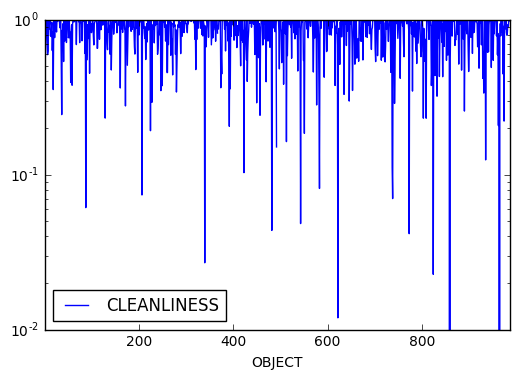

In [9]:
g141StampCleanlinessFrame[g141StampCleanlinessFrame['OBJECT'] < 5000].plot.line(x='OBJECT', y='CLEANLINESS', logy=True)

# Merge Catalogue quantities with cleanliness metric

In [10]:
print(objectCatalogues.keys())

dict_keys(['fin_F110', 'fin_F160'])


In [11]:
g141Frame = g141StampCleanlinessFrame.merge(objectCatalogues['fin_F160'], left_on='OBJECT', right_on='NUMBER')
g102Frame = g102StampCleanlinessFrame.merge(objectCatalogues['fin_F110'], left_on='OBJECT', right_on='NUMBER')

In [12]:
g141Frame = g141Frame.merge(redshiftEstimatesFrame, left_on='OBJECT', right_on='REDSHIFT_OBJECT')
g102Frame = g102Frame.merge(redshiftEstimatesFrame, left_on='OBJECT', right_on='REDSHIFT_OBJECT')

In [13]:
display(g141Frame)

,CLEANLINESS,OBJECT,RA_DEC_NAME,NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,X_WORLD,...,B_WORLD,THETA_WORLD,MAG_AUTO,MAGERR_AUTO,CLASS_STAR,FLAGS,MAX_REDSHIFT,MIN_REDSHIFT,REDSHIFT,REDSHIFT_OBJECT
0,0.770358,1,96_32.359375_-4.746259,1,1705.579,441.492,4.368,4.239,20.1,32.359375,...,0.000094,59.0,18.759,0.001,0.16,0,2.70,0.00,1.05,1
1,0.540048,2,96_32.341721_-4.711773,2,411.555,1608.004,4.440,3.198,52.6,32.341721,...,0.000074,28.2,18.590,0.001,0.22,0,2.91,0.00,0.03,2
2,0.695131,3,96_32.339222_-4.722685,3,914.873,1589.061,4.172,4.053,41.4,32.339222,...,0.000090,40.7,19.359,0.002,0.84,0,2.91,0.00,0.06,3
3,0.855527,4,96_32.367508_-4.722415,4,574.794,366.993,11.008,8.457,-12.0,32.367508,...,0.000191,86.6,19.147,0.002,0.03,2,2.94,0.00,0.30,4
4,0.931663,5,96_32.348476_-4.738227,5,1482.965,1007.126,8.532,4.965,72.1,32.348476,...,0.000118,3.4,19.386,0.002,0.10,0,2.85,0.00,0.72,5
5,1.000000,6,96_32.352814_-4.744349,6,1698.744,748.056,3.831,3.652,39.7,32.352814,...,0.000081,42.3,19.577,0.002,0.03,0,2.61,0.03,1.32,6
6,0.592992,7,96_32.343830_-4.713874,7,478.393,1492.200,8.658,4.384,14.8,32.343830,...,0.000092,63.0,19.626,0.002,0.10,0,2.85,0.00,0.66,7
7,0.625914,8,96_32.353062_-4.716213,8,472.894,1064.962,9.252,5.933,27.5,32.353062,...,0.000130,53.2,19.650,0.003,0.03,2,2.94,0.00,0.60,8
8,0.867207,10,96_32.361576_-4.732178,10,1068.003,510.187,8.318,6.731,-0.5,32.361576,...,0.000150,75.5,19.897,0.003,0.03,0,2.88,0.00,1.35,10
9,0.919332,11,96_32.336914_-4.742885,11,1819.683,1453.815,6.855,4.353,37.1,32.336914,...,0.000098,44.9,20.254,0.004,0.09,3,3.00,0.30,1.92,11


# Compute S/N for central 1000Å of G141 grism

In [14]:
g141SignalToNoiseRatios = []
spectrumObjects = []
spectrumFluxes = []
spectrumFluxErrors = []
for spectrumPath in g141SpectraPaths :
    spectrumObject = int(re.search(r'.*BEAM_([0-9]+)A.dat', spectrumPath).group(1))
    spectrumObjects.append(spectrumObject)
    g141Spectrum = np.loadtxt(spectrumPath)
    spectrumFrame = pd.DataFrame(g141Spectrum, columns = ['WAVELENGTH', 'FLUX', 'ERROR', 'CONTAM', 'ZEROTH'])
    centralWavelength = spectrumFrame.iloc[int(len(spectrumFrame.index)/2)].WAVELENGTH
    wavelengthCutRange = (centralWavelength - 500, centralWavelength+500)
    wavelengthCut = (spectrumFrame.WAVELENGTH > wavelengthCutRange[0]) & (spectrumFrame.WAVELENGTH < wavelengthCutRange[1])
    #print('wavelengthCutRange', wavelengthCutRange)
    spectrumFluxes.append(np.sum(spectrumFrame[wavelengthCut].FLUX))
    spectrumFluxErrors.append(np.sqrt(np.sum(spectrumFrame[wavelengthCut].ERROR**2)))
    signalToNoise = spectrumFluxes[-1]/spectrumFluxErrors[-1]
    #np.sum(spectrumFrame[wavelengthCut].FLUX)/np.sqrt(np.sum(spectrumFrame[wavelengthCut].ERROR**2))
    g141SignalToNoiseRatios.append(signalToNoise)
    #print('signalToNoise', signalToNoise)
    #spectrumFrame.dropna().plot.line(x='WAVELENGTH', y='FLUX', yerr='ERROR', logy=True)

g141SigToNoiseFrame = pd.DataFrame({'SPECTRUM_OBJECT': spectrumObjects, 'SIG_OVER_NOISE' : g141SignalToNoiseRatios, 'FLUX' : spectrumFluxes, 'FLUXERR' : spectrumFluxErrors}).set_index('SPECTRUM_OBJECT').sort_index()

g141Frame = g141Frame.merge(g141SigToNoiseFrame, left_on='OBJECT', right_index=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [15]:
g141Frame

,CLEANLINESS,OBJECT,RA_DEC_NAME,NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,X_WORLD,...,MAGERR_AUTO,CLASS_STAR,FLAGS,MAX_REDSHIFT,MIN_REDSHIFT,REDSHIFT,REDSHIFT_OBJECT,FLUX,FLUXERR,SIG_OVER_NOISE
0,0.770358,1,96_32.359375_-4.746259,1,1705.579,441.492,4.368,4.239,20.1,32.359375,...,0.001,0.16,0,2.70,0.00,1.05,1,2.270060e-16,1.186460e-18,191.330462
1,0.540048,2,96_32.341721_-4.711773,2,411.555,1608.004,4.440,3.198,52.6,32.341721,...,0.001,0.22,0,2.91,0.00,0.03,2,4.582936e-16,4.444595e-19,1031.125579
2,0.695131,3,96_32.339222_-4.722685,3,914.873,1589.061,4.172,4.053,41.4,32.339222,...,0.002,0.84,0,2.91,0.00,0.06,3,3.581555e-16,4.374741e-19,818.689580
3,0.855527,4,96_32.367508_-4.722415,4,574.794,366.993,11.008,8.457,-12.0,32.367508,...,0.002,0.03,2,2.94,0.00,0.30,4,3.209424e-16,4.794947e-19,669.334647
4,0.931663,5,96_32.348476_-4.738227,5,1482.965,1007.126,8.532,4.965,72.1,32.348476,...,0.002,0.10,0,2.85,0.00,0.72,5,2.090375e-16,4.189329e-19,498.976202
5,1.000000,6,96_32.352814_-4.744349,6,1698.744,748.056,3.831,3.652,39.7,32.352814,...,0.002,0.03,0,2.61,0.03,1.32,6,2.201356e-16,5.373685e-18,40.965486
6,0.592992,7,96_32.343830_-4.713874,7,478.393,1492.200,8.658,4.384,14.8,32.343830,...,0.002,0.10,0,2.85,0.00,0.66,7,1.550448e-16,4.222848e-19,367.157090
7,0.625914,8,96_32.353062_-4.716213,8,472.894,1064.962,9.252,5.933,27.5,32.353062,...,0.003,0.03,2,2.94,0.00,0.60,8,1.442203e-16,4.251330e-19,339.235665
8,0.867207,10,96_32.361576_-4.732178,10,1068.003,510.187,8.318,6.731,-0.5,32.361576,...,0.003,0.03,0,2.88,0.00,1.35,10,1.276638e-16,4.033576e-19,316.502773
9,0.919332,11,96_32.336914_-4.742885,11,1819.683,1453.815,6.855,4.353,37.1,32.336914,...,0.004,0.09,3,3.00,0.30,1.92,11,0.000000e+00,0.000000e+00,NaN


# Plot S/N versus catalogue parameters for sub-threshold values of CLEANLINESS

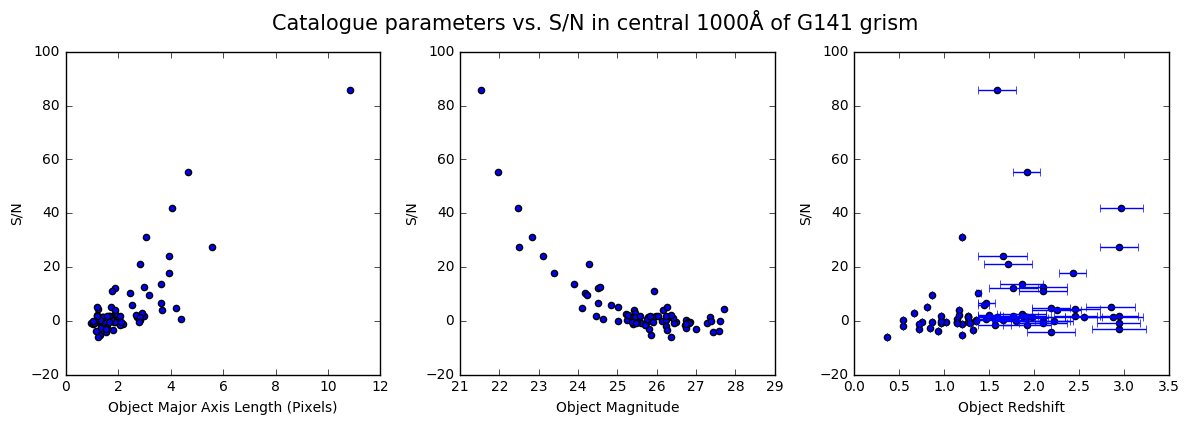

In [17]:
cleanlinessCut = (g141Frame.CLEANLINESS < 0.5)
signalToNoiseFig, sigToNoiseAxes = mplplot.subplots(figsize=(12, 4),
                                                    ncols = 3,
                                                    nrows = 1)

for axisIndex, (columnLabel, title, error, axis) in enumerate(zip(['A_IMAGE', 
                                                                   'MAG_AUTO', 
                                                                   'REDSHIFT'], 
                                                                  ['Object Major Axis Length (Pixels)', 
                                                                   'Object Magnitude', 
                                                                   'Object Redshift'],
                                                                  [None,
                                                                   None, 
                                                                   (g141Frame[cleanlinessCut].MIN_REDSHIFT, g141Frame[cleanlinessCut].MAX_REDSHIFT)],
                                                           sigToNoiseAxes.flatten())):
    
    g141Frame[cleanlinessCut].plot.scatter(ax=axis, x=columnLabel, y='SIG_OVER_NOISE', xerr=error)
    axis.set_xlabel(title)
    axis.set_ylabel('S/N')

mplplot.suptitle('Catalogue parameters vs. S/N in central 1000Å of G141 grism', y=1.05, size=15)
mplplot.tight_layout()

# Plot S/N versus flux in central 1000Å of G141 grism
Also added a by-eye "fit" overlay of S/N $\propto F^{0.8}$. 

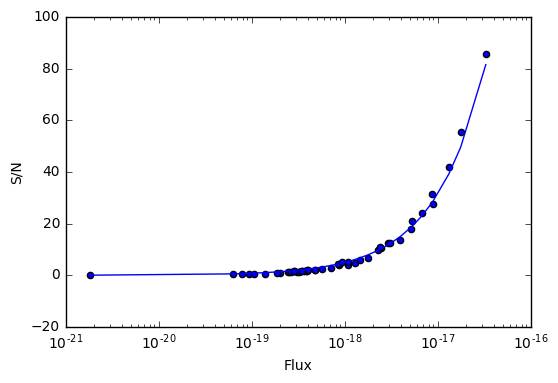

In [86]:
axes = g141Frame[cleanlinessCut & (g141Frame.FLUX > 1e-29)].plot.scatter(x='FLUX', y='SIG_OVER_NOISE', logx=True)
plotVals = zip(*sorted(zip(g141Frame[cleanlinessCut & (g141Frame.FLUX > 1e-29)].FLUX, 1.25e15*np.power(g141Frame[cleanlinessCut & (g141Frame.FLUX > 1e-29)].FLUX, 0.8)), key=lambda x : x[0]))
axes.plot(*plotVals)
axes.set_xlabel('Flux')
axes.set_ylabel('S/N')